## Scrapping Hotel booking data from three websites
- The websites are:
  - Booking.com
  - Expedia.com
  - Hotels.com
- Filtering criteria
  - City: Newyork
  - Checkin date: 1-10-2022
  - Checkout date: 27-10-2022

In [3]:
# Import required libraries
from bs4 import BeautifulSoup
import requests
import sys
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# google drive is used as a storage, that's why we need to import the library here and mount it
# It might ask you your permission to access your google drive 
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
# This method will save a pandas dataframe to csv file inside google drive
# You need to create a folder called 'Mini-project-1' in your root google drive path
def export_to_csv(file_name, df):
  path = f'/content/drive/My Drive/Mini-project-1/{file_name}'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    df.to_csv(f)

In [ ]:
# This method accept an alphanumeric phrase and it will return only the number 
def extract_number(phrase):
  return float(''.join(filter(str.isdigit, phrase))) if phrase else None

In [ ]:
def convert_to_scale_five(numeric_rating):
  return float(numeric_rating) * 0.5

Scrape from Booking.com

In [ ]:
total = 200
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36',
}

booking_base_url = 'https://www.booking.com/searchresults.en-gb.html?label=gen173nr-1FCAEoggI46AdIM1gEaEiIAQGYAQm4AQfIAQzYAQHoAQH4AQuIAgGoAgO4At_kopkGwAIB0gIkOTZlMzI0MGItNTQ3NS00NzBlLWFiMTQtMWUzZjYwNDZkZTk42AIG4AIB&sid=1224465bee028cf15314d2ed1408798f&aid=2046495&sb=1&sb_lp=1&src=index&src_elem=sb&error_url=https%3A%2F%2Fwww.booking.com%2Findex.en-gb.html%3Faid%3D2046495%26label%3Dgen173nr-1FCAEoggI46AdIM1gEaEiIAQGYAQm4AQfIAQzYAQHoAQH4AQuIAgGoAgO4At_kopkGwAIB0gIkOTZlMzI0MGItNTQ3NS00NzBlLWFiMTQtMWUzZjYwNDZkZTk42AIG4AIB%26sid%3D1224465bee028cf15314d2ed1408798f%26sb_price_type%3Dtotal%3Bsrpvid%3Dd15a36bcc421001f%26%26&ss=New+York&is_ski_area=0&ssne=New+York&ssne_untouched=New+York&dest_id=20088325&dest_type=city&checkin_year=2022&checkin_month=10&checkin_monthday=1&checkout_year=2022&checkout_month=10&checkout_monthday=27&group_adults=1&group_children=0&no_rooms=1&b_h4u_keep_filters=&from_sf=1&offset='

names = []
numeric_ratings = [] # This is out of 10
label_ratings = []
review_numbers = []
number_of_stars = []
original_prices = []
discount_prices = []
locations = []
distances = []
hotel_page_urls = []
descriptions = []
image_urls = []


def get_review(accommodation):
  return accommodation.find('div', attrs={'data-testid': 'review-score'})

def extract_review_number(review_phrase):
  return review_phrase.split(' ')[0]

def access_detail_info(hotel_url):
  hotel_detail_page = requests.get(hotel_url.split('?')[0], headers=headers)
  soup = BeautifulSoup(hotel_detail_page.content, 'lxml')
  images = []
  description = ''
  images = [thumbnail.find('img')['src'] for thumbnail in soup.find_all('div', class_='bh-photo-grid-thumb-cell')[0:2]]
  preview_images = [a.img['src'] for a in soup.find_all('a', attrs={'data-preview-image-layout':'main'})]
  images.extend(preview_images)
  description = ' '.join([p.text for p in soup.find('div', id='property_description_content').find_all('p')])
  return images, description

def scrape_booking():
  for i in range(0, total, 25):
    url = f'{booking_base_url}{i}'
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, 'lxml')
    accommodations = soup.find_all('div', attrs={'data-testid': 'property-card'})
    for accommodation in accommodations:
      try:
        images, descs = access_detail_info(accommodation.find('a', attrs={'data-testid':'title-link'})['href'])
        image_urls.append(images)
        descriptions.append(descs)
        names.append(accommodation.find('div', attrs={'data-testid':'title'}).text)
        numeric_ratings.append(get_review(accommodation).find('div', class_='b5cd09854e d10a6220b4').text)
        review_label = get_review(accommodation).find('div', class_='b5cd09854e f0d4d6a2f5 e46e88563a')
        label_ratings.append(review_label.text)
        review_numbers.append(extract_review_number(review_label.find_next_sibling('div').text))
        number_of_star = len(accommodation.find('div', attrs={'data-testid':'rating-stars'}).find_all('span'))
        number_of_stars.append(number_of_star)
        price_section = accommodation.find('div', attrs={'data-testid':'price-and-discounted-price'})
        try:
          original_prices.append(price_section.find('span', class_='fcab3ed991 bd73d13072').text)
          discount = price_section.find('span', class_='a0c113411d e293a04099')
          discount_prices.append(price_section.find('span', class_='a0c113411d e293a04099').text if discount else None)
        except:
          e = sys.exc_info()[0]
        locations.append(accommodation.find('span', attrs={'data-testid':'address'}).text)
        distance = accommodation.find('span', attrs={'data-testid':'distance'})
        distances.append(distance.text)
        availability_section = accommodation.find('div', attrs= {'data-testid': 'availability-cta'})
        hotel_page_urls.append(availability_section.a['href']) 
      except:
        e = sys.exc_info()[0]


In [59]:
# Run the scraping method for booking.com
scrape_booking()

In [ ]:
bookingcom_columns = ['Name', 'Numeric Rating', 'Label Rating', 'Review Number', 'Number of Stars', 'Original Prices', 'Discount Prices', 'Locations', 'Distance From City Center', 'Description', 'Hotel Page Url', 'Image Urls']
rows = zip(names, numeric_ratings, label_ratings, review_numbers, number_of_stars, original_prices, discount_prices, locations, distances, descriptions, hotel_page_urls, image_urls)
df = pd.DataFrame(data=rows, columns=bookingcom_columns)
export_to_csv('bookingcom-before.csv', df)

Scrape From Expedia and Hotel Website

In [ ]:
def get_price_text(price_section):
  return price_section.find('div', class_='uitk-text uitk-type-300 uitk-text-default-theme is-visually-hidden').text.split(' ')[-1]

def extract_original_price(price_summary):
  discount_price = None
  price = None
  if(price_summary.button):
    price = get_price_text(price_summary.button)
    discount_price = get_price_text(price_summary.button.find_next_sibling('div'))
  else:
    price = get_price_text(price_summary)
  return price, discount_price

def access_detail_info(hotel_url):
  hotel_detail_page = requests.get(hotel_url, headers=headers)
  soup = BeautifulSoup(hotel_detail_page.text, 'lxml')
  images = []
  number_of_stars = None
  address = None
  try:
    number_of_stars = soup.find('div', class_='uitk-rating').text.split(' ')[0]
    address = soup.find('div', attrs={'data-stid':'content-hotel-address'}).text
  except:
    e = sys.exc_info()[0]
    print(e)
  for figure in soup.find('div', id='Overview').find_all('figure', class_='uitk-image')[0:5]:
    images.append(figure.img['src'])
  
  return number_of_stars, images, address
   

def scrape_hotel_expedia(url, domain_url):
  names = []
  locations = [] 
  review_numbers = []
  number_ratings = []
  label_ratings = []
  original_prices = []
  discount_prices = []
  detail_urls = []
  images = []
  number_of_stars = []
  distances = []

  page_source = requests.get(url, headers=headers)
  soup = BeautifulSoup(page_source.text, 'lxml')

  results_section = soup.find('section', attrs={'data-stid':'section-results'})
  hotel_cards = results_section.find_all('li', attrs={'tabindex':-1})

  for hotel_card in hotel_cards:
    title_section = hotel_card.find('h2', class_='uitk-heading uitk-heading-5 overflow-wrap')
    names.append(title_section.text)
    distances.append(title_section.find_next_sibling('div').text)
    content_section = hotel_card.find('div', class_='uitk-card-content-section')
    review_section = content_section.find('span', class_='is-visually-hidden').find_previous_sibling('div')
    last_review_span = review_section.find_all('span')[-1]
    review_numbers.append(''.join(filter(str.isdigit, last_review_span.text)))
    number_ratings.append(review_section.find('span').text.split('/')[0])
    label_ratings.append(last_review_span.find_parent('span').find_previous_sibling('span').span.text)
    price_summary = hotel_card.find('div', attrs={'data-test-id':'price-summary-message-line'})
    original_price, discount_price = extract_original_price(price_summary)
    original_prices.append(original_price)
    discount_prices.append(discount_price)
    hotel_url_address = hotel_card.find('a', attrs={'data-stid': 'open-hotel-information'})['href']
    detail_urls.append(f'{domain_url}{hotel_url_address}')
    stars, image_urls, address = access_detail_info(f'{domain_url}{hotel_url_address}')
    locations.append(address)
    number_of_stars.append(stars)
    images.append(image_urls)

  return names, locations, review_numbers, number_ratings, label_ratings, original_prices, discount_prices, detail_urls, number_of_stars, distances, images

Scrapping Expedia.com Website

In [ ]:
expedia_domain_url = 'https://www.expedia.com'
expedia_base_url = f'{expedia_domain_url}/Hotel-Search?adults=1&d1=2022-10-01&d2=2022-10-27&destination=New%20York%20%28and%20vicinity%29%2C%20New%20York%2C%20United%20States%20of%20America&directFlights=false&endDate=2022-10-27&hotels-destination=New%20York%20%28and%20vicinity%29%2C%20New%20York%2C%20United%20States%20of%20America&hotels-destination=New%20York%20%28and%20vicinity%29%2C%20New%20York%2C%20United%20States%20of%20America&l10n=%5Bobject%20Object%5D&latLong=40.75668%2C-73.98647&localDateFormat=M%2Fd%2Fyyyy&partialStay=false&regionId=178293&semdtl=&startDate=2022-10-01&sort=DISTANCE&theme=&useRewards=false&userIntent='
expedia_names, expedia_locations, expedia_review_numbers, expedia_number_ratings, expedia_label_ratings, expedia_original_prices, expedia_discount_prices,  expedia_hotel_urls, expedia_number_of_stars, distances, expedia_images = scrape_hotel_expedia(expedia_base_url, expedia_domain_url)

In [ ]:
expedia_rows = zip(expedia_names, distances, expedia_number_of_stars, expedia_number_ratings, expedia_label_ratings, expedia_review_numbers, expedia_original_prices, expedia_discount_prices, expedia_locations, expedia_hotel_urls, expedia_images)
expedia_df = pd.DataFrame(data=expedia_rows, columns=['Name', 'Distance From City Center', 'Number of Stars', 'Numeric Rating', 'Label Rating', 'Review Number', 'Original Prices', 'Discount Prices', 'Locations', 'Hotel Page Url', 'Image Urls'])
export_to_csv('expedia-before.csv', expedia_df)

Scrapping Hotels.com Website

In [ ]:
hotels_domain_url = 'https://hotels.com'
hotels_base_url = 'https://hotels.com/Hotel-Search?adults=1&d1=2022-10-01&d2=2022-10-27&destination=New%20York%2C%20New%20York%2C%20Yhdysvallat&directFlights=false&endDate=2022-10-27&hotels-destination=New%20York%2C%20New%20York%2C%20Yhdysvallat&hotels-destination=New%20York%2C%20New%20York%2C%20Yhdysvallat&l10n=%5Bobject%20Object%5D&latLong=40.712843%2C-74.005966&localDateFormat=d.M.y&partialStay=false&regionId=2621&semdtl=&sort=DISTANCE&startDate=2022-10-01&theme=&useRewards=false&userIntent='

hotels_names, hotels_locations, hotels_review_numbers, hotels_number_ratings, hotels_label_ratings, hotels_original_prices, hotels_discount_prices,  hotels_hotel_urls, hotels_number_of_stars, hotels_distances, hotels_images = scrape_hotel_expedia(hotels_base_url, hotels_domain_url)


In [ ]:
hotels_rows = zip(hotels_names,hotels_distances, hotels_number_of_stars, hotels_number_ratings, hotels_label_ratings, hotels_review_numbers, hotels_original_prices, hotels_discount_prices, hotels_locations, hotels_hotel_urls, hotels_images)
hotels_df = pd.DataFrame(data=hotels_rows, columns=['Name', 'Distance From City Center', 'Number of Stars', 'Numeric Rating', 'Label Rating', 'Review Number', 'Original Prices', 'Discount Prices', 'Locations', 'Hotel Page Url', 'Image Urls'])
export_to_csv('hotels-before.csv', hotels_df)

## Data cleaning and feature engineering

Data cleaning - Booking.com

In [ ]:
df['Original Prices'] = df['Original Prices'].apply(extract_number)
df['Discount Prices'] = df['Discount Prices'].apply(extract_number)
df['Distance From City Center'] = df['Distance From City Center'].apply(extract_number)
df['Review Number'] = df['Review Number'].apply(extract_number)
df['Numeric Rating'] = df['Numeric Rating'].apply(convert_to_scale_five)

In [ ]:
export_to_csv('bookingcom-after.csv', df)

Data cleaning - Expedia.com

In [ ]:
expedia_df['Original Prices'] = expedia_df['Original Prices'].apply(extract_number)
expedia_df['Discount Prices'] = expedia_df['Discount Prices'].apply(extract_number)
expedia_df['Distance From City Center'] = expedia_df['Distance From City Center'].apply(extract_number)
expedia_df['Review Number'] = expedia_df['Review Number'].apply(extract_number)
expedia_df.head()
export_to_csv('expedia-after.csv', expedia_df)

Data cleaning - Hotels.com

In [ ]:
hotels_df['Original Prices'] = hotels_df['Original Prices'].apply(extract_number)
hotels_df['Discount Prices'] = hotels_df['Discount Prices'].apply(extract_number)
hotels_df['Distance From City Center'] = hotels_df['Distance From City Center'].apply(extract_number)
hotels_df['Review Number'] = hotels_df['Review Number'].apply(extract_number)
hotels_df.head()
export_to_csv('hotels-after.csv', hotels_df)

Combine the data

In [5]:
booking_df = pd.read_csv('/content/drive/MyDrive/Mini-project-1/bookingcom-after.csv')
expedia_df = pd.read_csv('/content/drive/MyDrive/Mini-project-1/expedia-after.csv')
hotels_df = pd.read_csv('/content/drive/MyDrive/Mini-project-1/hotels-after.csv')
hotelbooking_df = pd.concat([booking_df, expedia_df, hotels_df])
hotelbooking_df.head()

,Unnamed: 0,Name,Numeric Rating,Label Rating,Review Number,Number of Stars,Original Prices,Discount Prices,Locations,Distance From City Center,Description,Hotel Page Url,Image Urls
0,0,Hyatt Place New York City/Times Square,3.80,Good,12580.0,4.0,210125.0,NaN,"Hell's Kitchen, New York",17.0,You're eligible for a Genius discount at Hyat...,https://www.booking.com/hotel/us/hyatt-place-n...,['https://cf.bstatic.com/xdata/images/hotel/ma...
1,1,Freehand New York,4.00,Very good,1169.0,4.0,312239.0,NaN,"Gramercy, New York",31.0,"Located in the former George Washington Hotel,...",https://www.booking.com/hotel/us/freehand-new-...,['https://cf.bstatic.com/xdata/images/hotel/ma...
2,2,Hyatt Place NYC Chelsea,3.95,Good,3304.0,4.0,265622.0,NaN,"Chelsea, New York",28.0,You're eligible for a Genius discount at Hyat...,https://www.booking.com/hotel/us/hyatt-place-n...,['https://cf.bstatic.com/xdata/images/hotel/ma...
3,3,The Manhattan at Times Square,2.95,Review score,3464.0,4.0,209982.0,279976.0,"Manhattan, New York",7.0,You're eligible for a Genius discount at The ...,https://www.booking.com/hotel/us/the-manhattan...,['https://t-cf.bstatic.com/xdata/images/hotel/...
4,4,Fairfield Inn by Marriott New York Manhattan/F...,3.85,Good,2209.0,3.0,233831.0,NaN,"Wall Street - Financial District, New York",72.0,Fairfield Inn by Marriott New York Manhattan/F...,https://www.booking.com/hotel/us/fairfield-inn...,['https://cf.bstatic.com/xdata/images/hotel/ma...


In [6]:
# Dataset column names
hotelbooking_df.columns

Index(['Unnamed: 0', 'Name', 'Numeric Rating', 'Label Rating', 'Review Number',
       'Number of Stars', 'Original Prices', 'Discount Prices', 'Locations',
       'Distance From City Center', 'Description', 'Hotel Page Url',
       'Image Urls'],
      dtype='object')

In [7]:
# The first five records of the dataset
hotelbooking_df.head()

,Unnamed: 0,Name,Numeric Rating,Label Rating,Review Number,Number of Stars,Original Prices,Discount Prices,Locations,Distance From City Center,Description,Hotel Page Url,Image Urls
0,0,Hyatt Place New York City/Times Square,3.80,Good,12580.0,4.0,210125.0,NaN,"Hell's Kitchen, New York",17.0,You're eligible for a Genius discount at Hyat...,https://www.booking.com/hotel/us/hyatt-place-n...,['https://cf.bstatic.com/xdata/images/hotel/ma...
1,1,Freehand New York,4.00,Very good,1169.0,4.0,312239.0,NaN,"Gramercy, New York",31.0,"Located in the former George Washington Hotel,...",https://www.booking.com/hotel/us/freehand-new-...,['https://cf.bstatic.com/xdata/images/hotel/ma...
2,2,Hyatt Place NYC Chelsea,3.95,Good,3304.0,4.0,265622.0,NaN,"Chelsea, New York",28.0,You're eligible for a Genius discount at Hyat...,https://www.booking.com/hotel/us/hyatt-place-n...,['https://cf.bstatic.com/xdata/images/hotel/ma...
3,3,The Manhattan at Times Square,2.95,Review score,3464.0,4.0,209982.0,279976.0,"Manhattan, New York",7.0,You're eligible for a Genius discount at The ...,https://www.booking.com/hotel/us/the-manhattan...,['https://t-cf.bstatic.com/xdata/images/hotel/...
4,4,Fairfield Inn by Marriott New York Manhattan/F...,3.85,Good,2209.0,3.0,233831.0,NaN,"Wall Street - Financial District, New York",72.0,Fairfield Inn by Marriott New York Manhattan/F...,https://www.booking.com/hotel/us/fairfield-inn...,['https://cf.bstatic.com/xdata/images/hotel/ma...


In [8]:
# The shape of the dataset
hotelbooking_df.shape

(224, 13)

In [9]:
# The overall information of the dataset
hotelbooking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 0 to 19
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 224 non-null    int64  
 1   Name                       224 non-null    object 
 2   Numeric Rating             224 non-null    float64
 3   Label Rating               224 non-null    object 
 4   Review Number              224 non-null    float64
 5   Number of Stars            224 non-null    float64
 6   Original Prices            224 non-null    float64
 7   Discount Prices            50 non-null     float64
 8   Locations                  224 non-null    object 
 9   Distance From City Center  224 non-null    float64
 10  Description                184 non-null    object 
 11  Hotel Page Url             224 non-null    object 
 12  Image Urls                 224 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 24

In [10]:
# Set correct values for price column
def get_price(row):
  return row['Original Prices'] if pd.isnull(row['Discount Prices']) else row['Discount Prices']

In [11]:
hotelbooking_df['Price'] = hotelbooking_df.apply(lambda row: get_price(row), axis=1)
hotelbooking_df.head()

,Unnamed: 0,Name,Numeric Rating,Label Rating,Review Number,Number of Stars,Original Prices,Discount Prices,Locations,Distance From City Center,Description,Hotel Page Url,Image Urls,Price
0,0,Hyatt Place New York City/Times Square,3.80,Good,12580.0,4.0,210125.0,NaN,"Hell's Kitchen, New York",17.0,You're eligible for a Genius discount at Hyat...,https://www.booking.com/hotel/us/hyatt-place-n...,['https://cf.bstatic.com/xdata/images/hotel/ma...,210125.0
1,1,Freehand New York,4.00,Very good,1169.0,4.0,312239.0,NaN,"Gramercy, New York",31.0,"Located in the former George Washington Hotel,...",https://www.booking.com/hotel/us/freehand-new-...,['https://cf.bstatic.com/xdata/images/hotel/ma...,312239.0
2,2,Hyatt Place NYC Chelsea,3.95,Good,3304.0,4.0,265622.0,NaN,"Chelsea, New York",28.0,You're eligible for a Genius discount at Hyat...,https://www.booking.com/hotel/us/hyatt-place-n...,['https://cf.bstatic.com/xdata/images/hotel/ma...,265622.0
3,3,The Manhattan at Times Square,2.95,Review score,3464.0,4.0,209982.0,279976.0,"Manhattan, New York",7.0,You're eligible for a Genius discount at The ...,https://www.booking.com/hotel/us/the-manhattan...,['https://t-cf.bstatic.com/xdata/images/hotel/...,279976.0
4,4,Fairfield Inn by Marriott New York Manhattan/F...,3.85,Good,2209.0,3.0,233831.0,NaN,"Wall Street - Financial District, New York",72.0,Fairfield Inn by Marriott New York Manhattan/F...,https://www.booking.com/hotel/us/fairfield-inn...,['https://cf.bstatic.com/xdata/images/hotel/ma...,233831.0


## Exploratory data analysis (EDA)

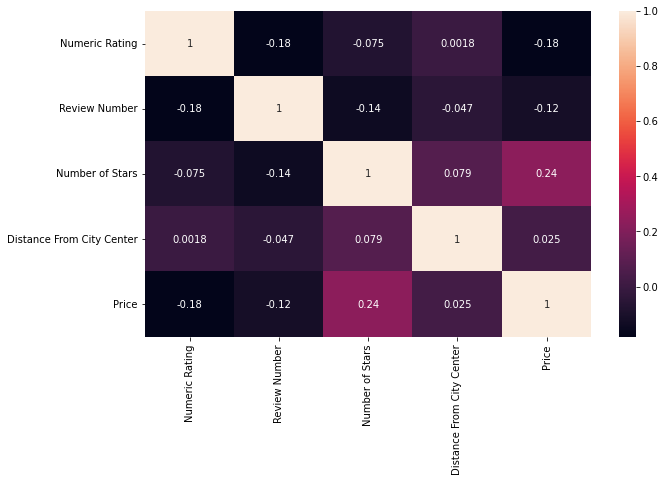

In [12]:
# Correlation between numeric rating, review number, number of stars, distance from city, price

numeric_df = hotelbooking_df[['Numeric Rating', 'Review Number', 'Number of Stars', 'Distance From City Center', 'Price']]
correlation_matrix = numeric_df.corr()
plt.subplots(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot = True)

(array([210.,  12.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.46000000e+02, 9.15702778e+05, 1.83115956e+06, 2.74661633e+06,
        3.66207311e+06, 4.57752989e+06, 5.49298667e+06, 6.40844344e+06,
        7.32390022e+06, 8.23935700e+06]),
 <a list of 9 Patch objects>)

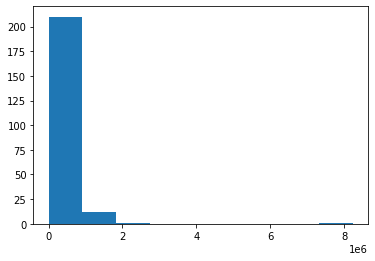

In [13]:
# Price range distribution
plt.hist(hotelbooking_df['Price'], bins=9)

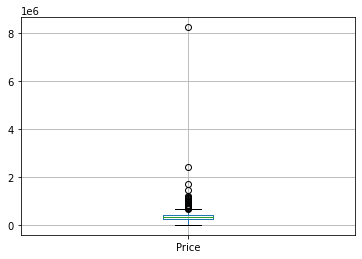

In [14]:
hotelbooking_df[['Price']].boxplot()

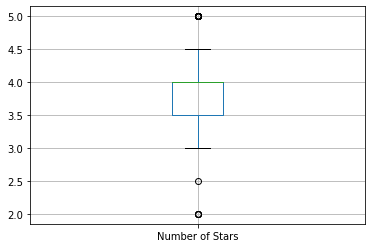

In [15]:
hotelbooking_df[['Number of Stars']].boxplot()

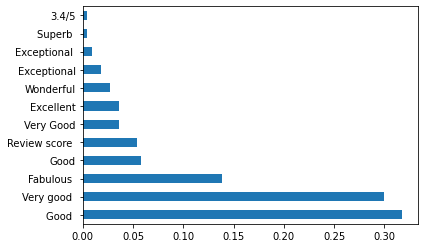

In [17]:

# The percentage of each label rating category.
hotelbooking_df['Label Rating'].value_counts(normalize=True)

hotelbooking_df['Label Rating'].value_counts(normalize=True).plot.barh()
plt.show()

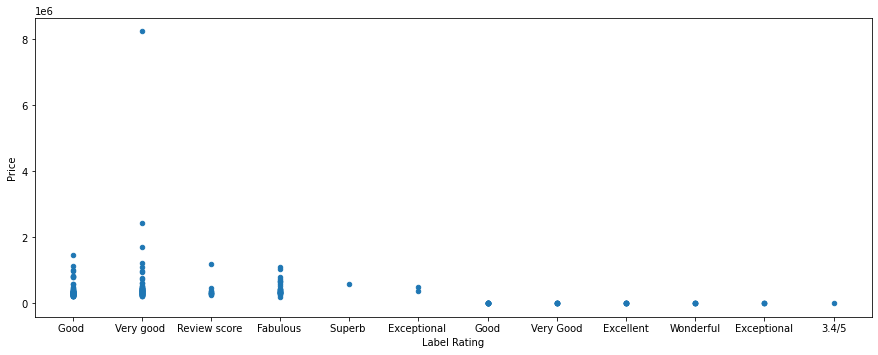

In [24]:
plt.rcParams["figure.figsize"] = (15,5.5)
hotelbooking_df.plot.scatter(x="Label Rating",y="Price")
plt.show()

User Interaction

In [41]:
# Filter hotels with in the provided price range

min_price = float(input('Please enter the minimum price: '))
max_price = float(input('Please enter the maximum price: '))

hotelbooking_df[(min_price <= hotelbooking_df['Price']) & (hotelbooking_df['Price'] <= max_price)]

Please enter the minimum price: 200
Please enter the maximum price: 300


,Unnamed: 0,Name,Numeric Rating,Label Rating,Review Number,Number of Stars,Original Prices,Discount Prices,Locations,Distance From City Center,Description,Hotel Page Url,Image Urls,Price
3,3,Hotel Shocard at Times Square,3.9,Good,643.0,3.0,341.0,290.0,"206 West 41st Street, New York, NY, 10036",11.0,NaN,https://www.expedia.com/New-York-Hotels-Hotel-...,['https://images.trvl-media.com/hotels/1200000...,290.0
12,12,Row NYC,3.5,Good,3913.0,4.0,330.0,280.0,"700 8th Avenue, New York, NY, 10036",19.0,NaN,https://www.expedia.com/New-York-Hotels-Row-NY...,['https://images.trvl-media.com/hotels/1000000...,280.0
15,15,OYO Times Square,3.4,3.4/5,1001.0,4.0,337.0,269.0,"157 West 47th Street, New York, NY, 10036",2.0,NaN,https://www.expedia.com/New-York-Hotels-OYO-Ti...,['https://images.trvl-media.com/hotels/1000000...,269.0
3,3,Aloft Manhattan Downtown - Financial District,8.0,Very Good,948.0,3.0,284.0,NaN,"49-53 Ann Street, New York, NY, 10038",18.0,NaN,https://hotels.com/ho480123/aloft-manhattan-do...,['https://images.trvl-media.com/hotels/1000000...,284.0
7,7,"Holiday Inn New York City - Wall Street, an IH...",7.4,Good,998.0,3.0,274.0,247.0,"51 Nassau St., New York, NY, 10038",32.0,NaN,https://hotels.com/ho272124/holiday-inn-new-yo...,['https://images.trvl-media.com/hotels/3000000...,247.0
9,9,Sonder at One Platt,8.2,Very Good,107.0,3.5,278.0,NaN,"1 Platt Street, New York, NY, 10038",37.0,NaN,https://hotels.com/ho1286878560/sonder-at-one-...,['https://images.trvl-media.com/hotels/4100000...,278.0
10,10,Residence Inn by Marriott New York Downtown Ma...,8.0,Very Good,65.0,3.0,355.0,284.0,"215 PEARL STREET, New York, NY, 10038",39.0,NaN,https://hotels.com/ho1253090944/residence-inn-...,['https://images.trvl-media.com/hotels/4000000...,284.0
11,11,Courtyard by Marriott New York Downtown Manhat...,7.4,Good,301.0,3.0,336.0,286.0,"215 PEARL STREET, New York, NY, 10038",4.0,NaN,https://hotels.com/ho1183170208/courtyard-by-m...,['https://images.trvl-media.com/hotels/3700000...,286.0
18,18,Holiday Inn Express New York City- Wall Street...,7.6,Good,1001.0,2.5,274.0,246.0,"126 Water St, New York, NY, 10005",51.0,NaN,https://hotels.com/ho311346/holiday-inn-expres...,['https://images.trvl-media.com/hotels/3000000...,246.0


In [43]:
# Filter hotels by number of stars

num_stars = float(input('Please enter number of stars(between 1-5): '))
hotelbooking_df[hotelbooking_df['Number of Stars'] == num_stars]

Please enter number of stars(between 1-5)6


,Unnamed: 0,Name,Numeric Rating,Label Rating,Review Number,Number of Stars,Original Prices,Discount Prices,Locations,Distance From City Center,Description,Hotel Page Url,Image Urls,Price


In [44]:
# Filter hotels by distance from city center

min_distance = float(input('Please minimum distance in mile: '))
max_distance = float(input('Please maximum distance in mile: '))
hotelbooking_df[(min_distance <= hotelbooking_df['Distance From City Center']) & (hotelbooking_df['Distance From City Center'] <= max_distance)]


Please minimum distance2
Please maximum distance10


,Unnamed: 0,Name,Numeric Rating,Label Rating,Review Number,Number of Stars,Original Prices,Discount Prices,Locations,Distance From City Center,Description,Hotel Page Url,Image Urls,Price
3,3,The Manhattan at Times Square,2.95,Review score,3464.0,4.0,209982.0,279976.0,"Manhattan, New York",7.0,You're eligible for a Genius discount at The ...,https://www.booking.com/hotel/us/the-manhattan...,['https://t-cf.bstatic.com/xdata/images/hotel/...,279976.0
7,7,Park Lane New York,4.20,Very good,919.0,5.0,614020.0,NaN,"Manhattan, New York",6.0,You're eligible for a Genius discount at Park...,https://www.booking.com/hotel/us/park-lane-new...,['https://cf.bstatic.com/xdata/images/hotel/ma...,614020.0
8,8,citizenM New York Times Square,4.40,Fabulous,3150.0,4.0,273000.0,321177.0,"Manhattan, New York",8.0,"Located right in the heart of Manhattan, this ...",https://www.booking.com/hotel/us/citizenm-new-...,['https://cf.bstatic.com/xdata/images/hotel/ma...,321177.0
12,12,CIVILIAN Hotel,4.20,Very good,688.0,4.0,276173.0,NaN,"Hell's Kitchen, New York",9.0,"Boasting a bar and a terrace, CIVILIAN Hotel i...",https://www.booking.com/hotel/us/civilian-nyc....,['https://t-cf.bstatic.com/xdata/images/hotel/...,276173.0
15,15,Sheraton New York Times Square Hotel,3.75,Good,867.0,4.0,229901.0,NaN,"Manhattan, New York",6.0,Featuring an extensive health center and a tic...,https://www.booking.com/hotel/us/sheraton-new-...,['https://t-cf.bstatic.com/xdata/images/hotel/...,229901.0
17,17,The Time New York,3.85,Good,1200.0,4.0,276395.0,NaN,"Manhattan, New York",8.0,"Located 300 m from Broadway theatres, The Time...",https://www.booking.com/hotel/us/the-time.en-g...,['https://t-cf.bstatic.com/xdata/images/hotel/...,276395.0
29,29,Sonder at One Platt,3.95,Good,386.0,3.0,219189.0,NaN,"Wall Street - Financial District, New York",7.0,"Located in New York, near National September 1...",https://www.booking.com/hotel/us/sonder-116-jo...,['https://cf.bstatic.com/xdata/images/hotel/ma...,219189.0
31,31,Kixby,4.30,Fabulous,127.0,4.0,341460.0,NaN,"Manhattan, New York",2.0,"Offering a seasonal rooftop bar, Kixby is step...",https://www.booking.com/hotel/us/metro.en-gb.h...,['https://cf.bstatic.com/xdata/images/hotel/ma...,341460.0
33,33,"Holiday Inn Express - Times Square South, an I...",3.90,Good,3120.0,3.0,262012.0,NaN,"Manhattan, New York",2.0,Within 8 minutes' walk of Times Square and the...,https://www.booking.com/hotel/us/holiday-inn-e...,['https://cf.bstatic.com/xdata/images/hotel/ma...,262012.0
54,54,Courtyard New York Manhattan/Times Square,4.15,Very good,1034.0,3.0,312062.0,367132.0,"SoHo, New York",5.0,You're eligible for a Genius discount at Cour...,https://www.booking.com/hotel/us/four-points-b...,['https://t-cf.bstatic.com/xdata/images/hotel/...,367132.0


In [45]:
# Filter hotels by review score

min_review_score = float(input('Please minimum review_score in mile: '))
max_review_score = float(input('Please maximum review_score in mile: '))
hotelbooking_df[(min_review_score <= hotelbooking_df['Review Number']) & (hotelbooking_df['Review Number'] <= max_review_score)]


Please minimum review_score in mile: 300
Please maximum review_score in mile: 350


,Unnamed: 0,Name,Numeric Rating,Label Rating,Review Number,Number of Stars,Original Prices,Discount Prices,Locations,Distance From City Center,Description,Hotel Page Url,Image Urls,Price
51,51,Courtyard New York Downtown Manhattan/Financia...,3.6,Good,329.0,4.0,334678.0,NaN,"Lower East Side, New York",52.0,"Boasting a restaurant, free bikes, fitness cen...",https://www.booking.com/hotel/us/indigo-lower-...,['https://t-cf.bstatic.com/xdata/images/hotel/...,334678.0
171,171,Mondrian Park Avenue,3.5,Good,304.0,5.0,987554.0,NaN,"Manhattan, New York",6.0,You're eligible for a Genius discount at Mond...,https://www.booking.com/hotel/us/the-ritz-carl...,['https://cf.bstatic.com/xdata/images/hotel/ma...,987554.0
9,9,Merrion Row Hotel and Public House,4.7,Exceptional,319.0,4.0,784.0,NaN,"119 W 45th St, New York, NY, 10036",16.0,NaN,https://www.expedia.com/New-York-Hotels-Merrio...,['https://images.trvl-media.com/hotels/2500000...,784.0
11,11,Courtyard by Marriott New York Downtown Manhat...,7.4,Good,301.0,3.0,336.0,286.0,"215 PEARL STREET, New York, NY, 10038",4.0,NaN,https://hotels.com/ho1183170208/courtyard-by-m...,['https://images.trvl-media.com/hotels/3700000...,286.0


In [49]:
# Sorted by user preference
col_name = input('Please enter sorted by feature(column): ')
hotelbooking_df.sort_values(by=[col_name])

Please enter sorted by feature(column): Price


,Unnamed: 0,Name,Numeric Rating,Label Rating,Review Number,Number of Stars,Original Prices,Discount Prices,Locations,Distance From City Center,Description,Hotel Page Url,Image Urls,Price
18,18,Holiday Inn Express New York City- Wall Street...,7.60,Good,1001.0,2.5,274.0,246.0,"126 Water St, New York, NY, 10005",51.0,NaN,https://hotels.com/ho311346/holiday-inn-expres...,['https://images.trvl-media.com/hotels/3000000...,246.0
7,7,"Holiday Inn New York City - Wall Street, an IH...",7.40,Good,998.0,3.0,274.0,247.0,"51 Nassau St., New York, NY, 10038",32.0,NaN,https://hotels.com/ho272124/holiday-inn-new-yo...,['https://images.trvl-media.com/hotels/3000000...,247.0
15,15,OYO Times Square,3.40,3.4/5,1001.0,4.0,337.0,269.0,"157 West 47th Street, New York, NY, 10036",2.0,NaN,https://www.expedia.com/New-York-Hotels-OYO-Ti...,['https://images.trvl-media.com/hotels/1000000...,269.0
9,9,Sonder at One Platt,8.20,Very Good,107.0,3.5,278.0,NaN,"1 Platt Street, New York, NY, 10038",37.0,NaN,https://hotels.com/ho1286878560/sonder-at-one-...,['https://images.trvl-media.com/hotels/4100000...,278.0
12,12,Row NYC,3.50,Good,3913.0,4.0,330.0,280.0,"700 8th Avenue, New York, NY, 10036",19.0,NaN,https://www.expedia.com/New-York-Hotels-Row-NY...,['https://images.trvl-media.com/hotels/1000000...,280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,179,The Dominick Hotel,4.25,Very good,22.0,5.0,1206553.0,NaN,"NoMad, New York",26.0,You're eligible for a Genius discount at The ...,https://www.booking.com/hotel/us/the-ritz-carl...,['https://t-cf.bstatic.com/xdata/images/hotel/...,1206553.0
128,128,New York Marriott Downtown,3.95,Good,108.0,5.0,1462949.0,NaN,"Tribeca, New York",65.0,The New York Marriott Downtown Hotel has 506 g...,https://www.booking.com/hotel/us/four-seasons-...,['https://t-cf.bstatic.com/xdata/images/hotel/...,1462949.0
140,140,"EVEN Hotel New York Times Square South, an IHG...",4.15,Very good,288.0,4.0,1689681.0,NaN,"Tribeca, New York",63.0,Even Hotel New York Times Square South offers ...,https://www.booking.com/hotel/us/the-smyth-new...,['https://cf.bstatic.com/xdata/images/hotel/ma...,1689681.0
152,152,ModernHaus SoHo,4.15,Very good,589.0,5.0,2428508.0,NaN,"Upper West Side, New York",100.0,You're eligible for a Genius discount at Mode...,https://www.booking.com/hotel/us/trump-interna...,['https://t-cf.bstatic.com/xdata/images/hotel/...,2428508.0


In [59]:
# Get the information of a hotel

usr_name = input('Please enter hotel name: ')
name = hotelbooking_df['Name']
print('Name: ', hotelbooking_df.loc[name == usr_name].iloc[0]['Name'])
print('Address: ', hotelbooking_df.loc[name == usr_name].iloc[0]['Locations'])
print('Price: ', hotelbooking_df.loc[name == usr_name].iloc[0]['Price'])
print('Review number: ', hotelbooking_df.loc[name == usr_name].iloc[0]['Review Number'])
print('Review Numeric Rating: ', hotelbooking_df.loc[name == usr_name].iloc[0]['Numeric Rating'])
print('Summary: ', hotelbooking_df.loc[name == usr_name].iloc[0]['Description'])
print('Image Urls: ', hotelbooking_df.loc[name == usr_name].iloc[0]['Image Urls'])

Please enter hotel name: ModernHaus SoHo
Name:  ModernHaus SoHo
Address:  Upper West Side, New York
Price:  2428508.0
Review number:  589.0
Review Numeric Rating:  4.15
Summary:   You're eligible for a Genius discount at ModernHaus SoHo! To save at this property, all you have to do is sign in. Located in SoHo, an area known for fashion, art and shops, this hotel offers two bars and a restaurant on-site. Guests can enjoy views of the city from the rooftop. Rooms at ModernHaus SoHo boast a floor-to-ceiling glass wall separating the bathroom from the living quarters. Each room includes wood floors, 42-inch flat-screen TVs, Nespresso coffee, and Le Labo bath amenities. Wifi is included. Jumpin Jacks, reached by a glass elevator, offers craft coffee by day and signature cocktails in the evening. A two-story glass wall overlooks the outdoor Urban Garden and the Avenue of the Americas. The rooftop lounge, Jimmy, offers views of the Hudson River and features a seasonal outdoor pool. The James 